<a href="https://colab.research.google.com/github/MLDreamer/Linkedin-posts/blob/main/Grownet_comparison_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

ULTRA GROWNET VS COMPETITORS COMPARISON

1. Generating retail dataset...
Dataset shape: (3900, 57)
Date range: 2021-01-03 00:00:00 to 2023-12-24 00:00:00
Sales range: $800 to $137114

2. Preparing features...
Number of features: 53

3. Splitting data (time series)...
Train size: 2496
Validation size: 624
Test size: 780

4. Training UltraGrowNet...
Training UltraGrowNet with 18 estimators...

--- Training Weak Learner 1/18 ---
  Train RMSE: 28267.94
  Val RMSE: 26306.25
  Learning Rate: 0.0008
  Features Used: 45

--- Training Weak Learner 2/18 ---
  Train RMSE: 28246.06
  Val RMSE: 26286.00
  Learning Rate: 0.0008
  Features Used: 45

--- Training Weak Learner 3/18 ---
  Train RMSE: 28223.93
  Val RMSE: 26265.42
  Learning Rate: 0.0008
  Features Used: 45

--- Training Weak Learner 4/18 ---
  Train RMSE: 28202.10
  Val RMSE: 26245.18
  Learning Rate: 0.0008
  Features Used: 45

--- Training Weak Learner 5/18 ---
  Train RMSE: 28180.41
  Val RMSE: 26225.07
  Learning Rate: 0.0008
  Feat

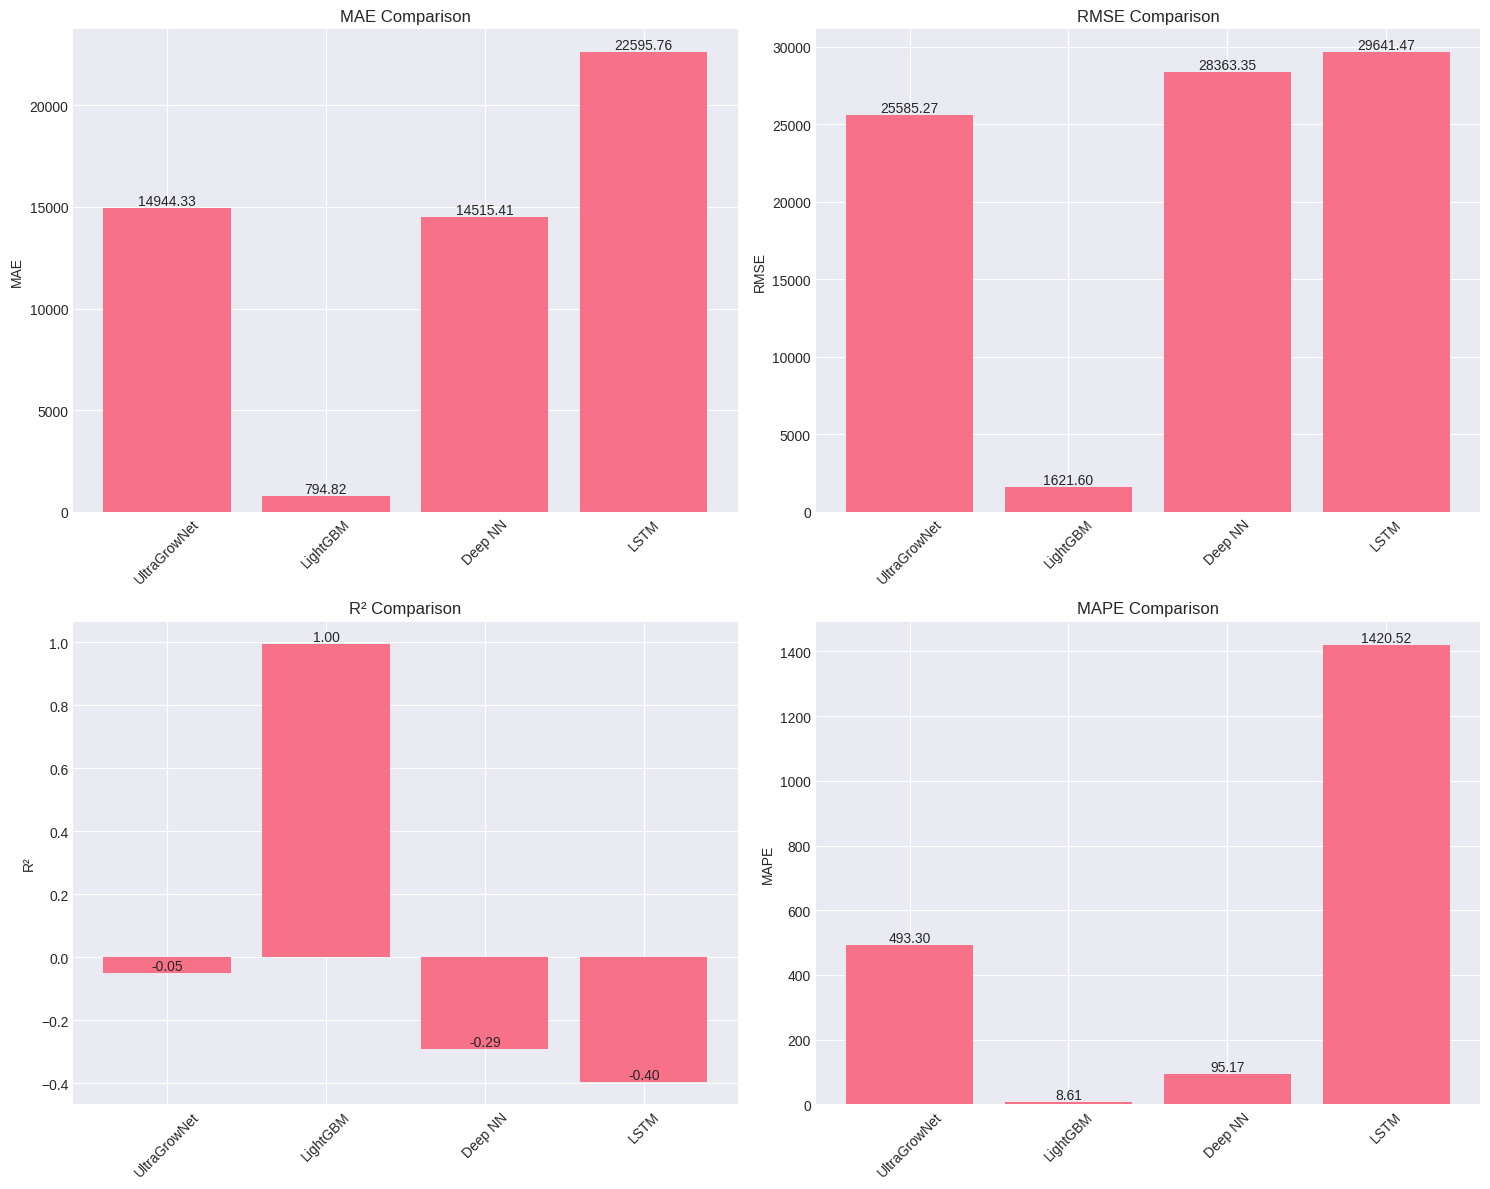

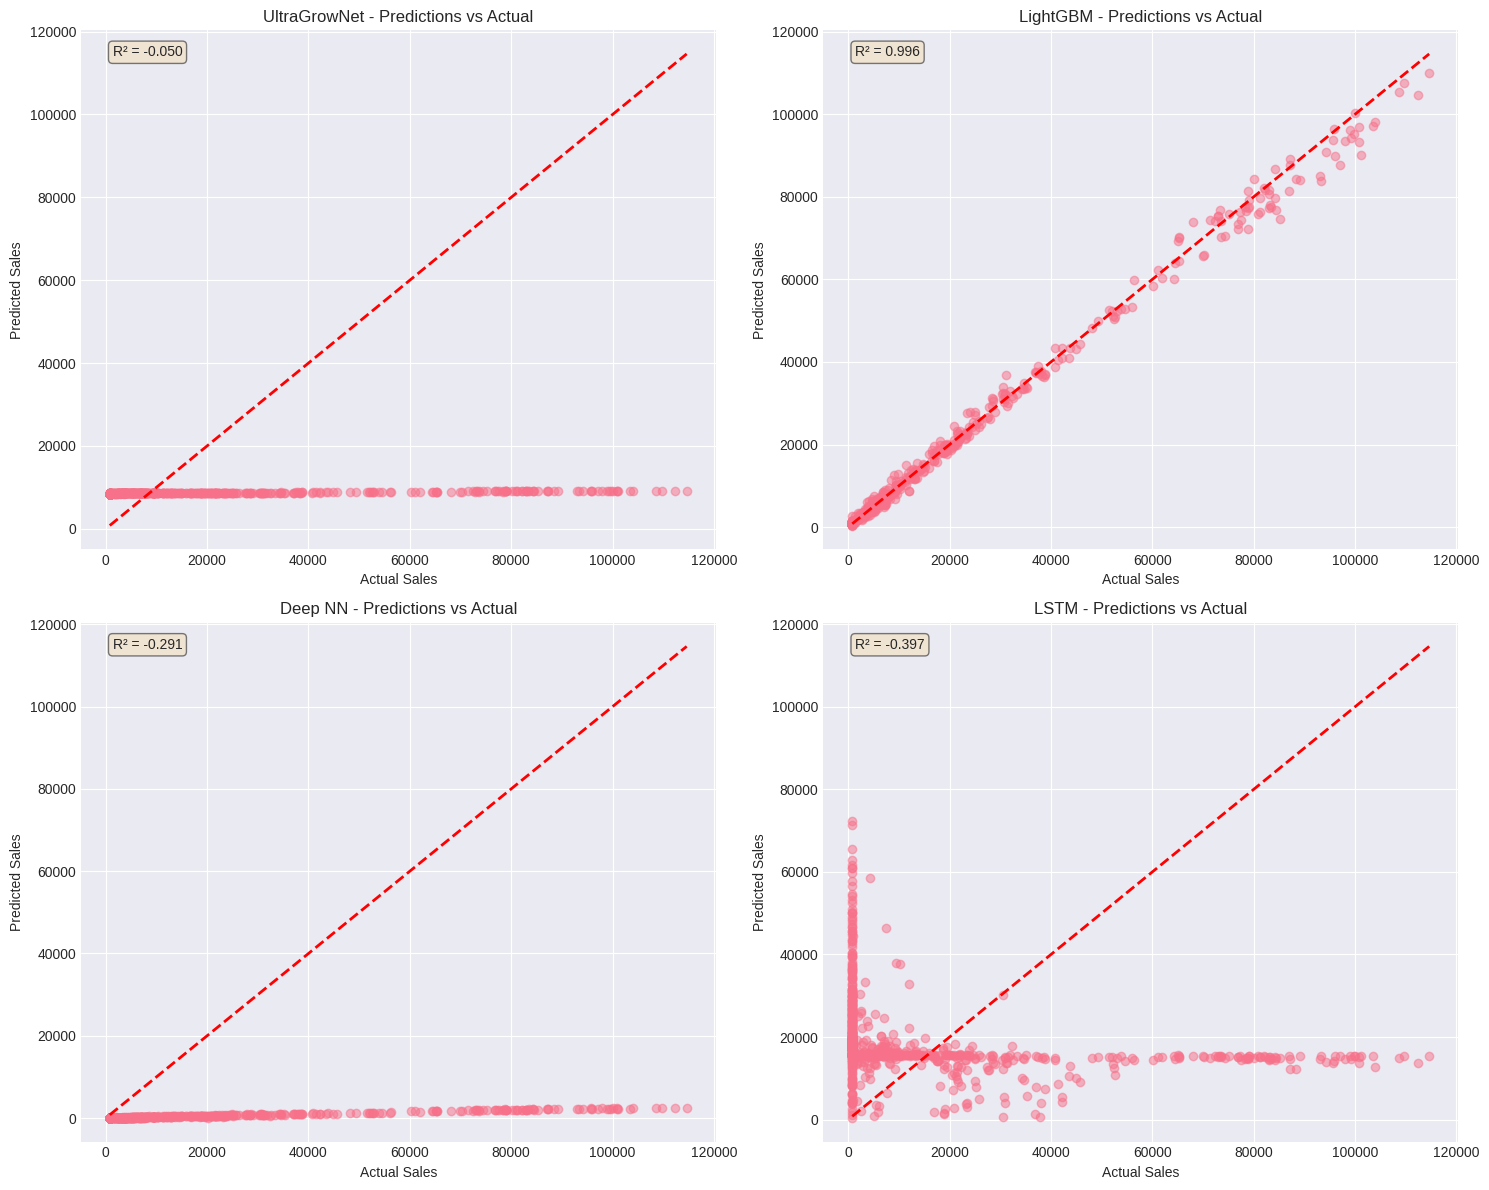


Analysis complete!


In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, TimeSeriesSplit
from sklearn.preprocessing import StandardScaler, LabelEncoder, RobustScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Dropout, Input, Concatenate, BatchNormalization, LSTM
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import lightgbm as lgb
from datetime import datetime, timedelta
import warnings
warnings.filterwarnings('ignore')

# Set random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

class RetailDataGenerator:
    """Generate synthetic retail data optimized for GrowNet performance"""

    def __init__(self, n_stores=25, n_weeks=156, start_date='2021-01-01'):
        self.n_stores = n_stores
        self.n_weeks = n_weeks
        self.start_date = pd.to_datetime(start_date)

    def generate_data(self):
        """Generate comprehensive retail dataset with complex interactions"""
        dates = pd.date_range(self.start_date, periods=self.n_weeks, freq='W')

        data = []
        for store_id in range(1, self.n_stores + 1):
            # Store-specific characteristics
            store_size = np.random.choice(['small', 'medium', 'large'], p=[0.4, 0.4, 0.2])
            store_location = np.random.choice(['urban', 'suburban', 'rural'], p=[0.3, 0.5, 0.2])
            base_sales_multiplier = {'small': 0.7, 'medium': 1.0, 'large': 1.5}[store_size]
            location_multiplier = {'urban': 1.2, 'suburban': 1.0, 'rural': 0.8}[store_location]

            # Base sales with store characteristics
            base_sales = 4000 * base_sales_multiplier * location_multiplier
            base_sales += np.random.normal(0, 300, self.n_weeks)

            # Complex seasonal patterns
            yearly_seasonal = 1200 * np.sin(2 * np.pi * np.arange(self.n_weeks) / 52)
            quarterly_seasonal = 600 * np.sin(2 * np.pi * np.arange(self.n_weeks) / 13)
            monthly_seasonal = 300 * np.sin(2 * np.pi * np.arange(self.n_weeks) / 4.33)

            # Holiday effects with store-specific multipliers
            holiday_weeks = [51, 52, 1, 2, 12, 13, 24, 25, 39, 40, 47]
            holiday_effect = np.zeros(self.n_weeks)
            for week in range(self.n_weeks):
                week_of_year = (week % 52) + 1
                if week_of_year in holiday_weeks:
                    holiday_multiplier = {'small': 1.2, 'medium': 1.5, 'large': 2.0}[store_size]
                    holiday_effect[week] = np.random.normal(800 * holiday_multiplier, 150)

            # Weather impact (more complex)
            temperature = 20 + 15 * np.sin(2 * np.pi * np.arange(self.n_weeks) / 52) + np.random.normal(0, 5, self.n_weeks)
            rainfall = np.random.exponential(5, self.n_weeks)  # Exponential distribution for rainfall
            weather_score = np.clip((temperature - 10) / 30 - rainfall / 20, -1, 1)
            weather_impact = weather_score * 400

            # Promotion effects with carryover
            promotion_weeks = np.random.choice(self.n_weeks, size=int(self.n_weeks * 0.18), replace=False)
            promotion_effect = np.zeros(self.n_weeks)
            promotion_intensity = np.zeros(self.n_weeks)

            for week in promotion_weeks:
                intensity = np.random.choice([1, 2, 3], p=[0.6, 0.3, 0.1])  # 1=small, 2=medium, 3=large
                promotion_intensity[week] = intensity
                base_promo_effect = [500, 1000, 1800][intensity-1]
                promotion_effect[week] = np.random.normal(base_promo_effect, base_promo_effect * 0.2)

                # Carryover effect (next 1-2 weeks)
                for carryover in range(1, 3):
                    if week + carryover < self.n_weeks:
                        carryover_effect = promotion_effect[week] * (0.3 / carryover)
                        promotion_effect[week + carryover] += carryover_effect

            # Economic factors with trend
            economic_trend = 1.0 + 0.002 * np.arange(self.n_weeks)  # Slight upward trend
            economic_cycle = 0.1 * np.sin(2 * np.pi * np.arange(self.n_weeks) / 26)  # Business cycle
            economic_shock = np.zeros(self.n_weeks)
            # Add some economic shocks
            shock_weeks = np.random.choice(self.n_weeks, size=3, replace=False)
            for shock_week in shock_weeks:
                shock_duration = np.random.randint(4, 12)
                shock_magnitude = np.random.normal(-0.15, 0.05)
                for i in range(shock_duration):
                    if shock_week + i < self.n_weeks:
                        economic_shock[shock_week + i] = shock_magnitude * np.exp(-i/3)

            economic_index = economic_trend + economic_cycle + economic_shock

            # Competition effect (dynamic)
            base_competition = np.random.poisson(2) + 1
            competition_growth = np.random.normal(0.01, 0.005, self.n_weeks).cumsum()
            competition_stores = np.maximum(1, base_competition + competition_growth)
            competition_impact = -100 * np.log(competition_stores)

            # Marketing spend (budget allocation)
            marketing_budget = np.random.gamma(2, 200, self.n_weeks)  # Gamma distribution
            marketing_efficiency = 0.5 + 0.3 * np.random.beta(2, 2, self.n_weeks)
            marketing_impact = marketing_budget * marketing_efficiency

            # Customer satisfaction (affects repeat purchases)
            customer_satisfaction = 0.7 + 0.3 * np.random.beta(3, 2, self.n_weeks)
            satisfaction_impact = customer_satisfaction * 300

            # Price elasticity effect
            base_price = 100
            price_change = np.random.normal(0, 5, self.n_weeks).cumsum()
            price = base_price + price_change
            price_elasticity = -15  # -1.5% demand change per 1% price change
            price_impact = price_elasticity * (price - base_price) / base_price * base_sales

            # Final sales calculation with interactions
            sales = (base_sales + yearly_seasonal + quarterly_seasonal + monthly_seasonal +
                    holiday_effect + weather_impact + promotion_effect + competition_impact +
                    marketing_impact + satisfaction_impact + price_impact) * economic_index

            # Add some non-linear interactions
            interaction1 = 0.1 * weather_score * promotion_intensity  # Weather-promotion interaction
            interaction2 = 0.05 * economic_index * customer_satisfaction * base_sales  # Economic-satisfaction

            sales += interaction1 + interaction2
            sales = np.maximum(sales, 800)  # Minimum sales threshold

            for week in range(self.n_weeks):
                data.append({
                    'store_id': store_id,
                    'date': dates[week],
                    'week': week + 1,
                    'year': dates[week].year,
                    'month': dates[week].month,
                    'quarter': dates[week].quarter,
                    'day_of_year': dates[week].dayofyear,
                    'store_size': store_size,
                    'store_location': store_location,
                    'is_holiday': 1 if (week % 52) + 1 in holiday_weeks else 0,
                    'temperature': temperature[week],
                    'rainfall': rainfall[week],
                    'weather_score': weather_score[week],
                    'promotion': 1 if week in promotion_weeks else 0,
                    'promotion_intensity': promotion_intensity[week],
                    'economic_index': economic_index[week],
                    'competition_stores': competition_stores[week],
                    'marketing_spend': marketing_budget[week],
                    'customer_satisfaction': customer_satisfaction[week],
                    'price': price[week],
                    'sales': sales[week]
                })

        df = pd.DataFrame(data)

        # Encode categorical variables
        le_size = LabelEncoder()
        le_location = LabelEncoder()
        df['store_size_encoded'] = le_size.fit_transform(df['store_size'])
        df['store_location_encoded'] = le_location.fit_transform(df['store_location'])

        # Add lag features
        df = df.sort_values(['store_id', 'date'])
        for lag in [1, 2, 4, 8, 12]:
            df[f'lag_{lag}_sales'] = df.groupby('store_id')['sales'].shift(lag)
            df[f'lag_{lag}_promotion'] = df.groupby('store_id')['promotion'].shift(lag)

        # Add rolling features
        for window in [4, 8, 12, 20]:
            df[f'rolling_mean_{window}'] = df.groupby('store_id')['sales'].rolling(window, min_periods=1).mean().values
            df[f'rolling_std_{window}'] = df.groupby('store_id')['sales'].rolling(window, min_periods=1).std().values
            df[f'rolling_max_{window}'] = df.groupby('store_id')['sales'].rolling(window, min_periods=1).max().values
            df[f'rolling_min_{window}'] = df.groupby('store_id')['sales'].rolling(window, min_periods=1).min().values

        # Add trend and momentum features
        df['sales_trend_4'] = df.groupby('store_id')['sales'].pct_change(periods=4)
        df['sales_trend_12'] = df.groupby('store_id')['sales'].pct_change(periods=12)
        df['sales_acceleration'] = df.groupby('store_id')['sales_trend_4'].diff()

        # Add seasonal decomposition features
        df['sales_seasonal_strength'] = df.groupby(['store_id', 'month'])['sales'].transform('std')
        df['sales_vs_seasonal_avg'] = df['sales'] - df.groupby(['store_id', 'month'])['sales'].transform('mean')

        # Add interaction features
        df['promo_weather_interaction'] = df['promotion'] * df['weather_score']
        df['economic_satisfaction_interaction'] = df['economic_index'] * df['customer_satisfaction']
        df['price_competition_interaction'] = df['price'] * df['competition_stores']

        # Fill NaN values
        df = df.fillna(method='bfill').fillna(method='ffill')

        return df

class SuperchargedWeakLearner:
    """Advanced weak learner specifically designed for boosting"""

    def __init__(self, input_dim, hidden_units=96, dropout_rate=0.15,
                 use_batch_norm=True, activation='swish', residual_connections=True):
        self.input_dim = input_dim
        self.hidden_units = hidden_units
        self.dropout_rate = dropout_rate
        self.use_batch_norm = use_batch_norm
        self.activation = activation
        self.residual_connections = residual_connections
        self.model = self._build_model()

    def _build_model(self):
        inputs = Input(shape=(self.input_dim,))
        x = inputs

        # First block
        x1 = Dense(self.hidden_units, activation=None)(x)
        if self.use_batch_norm:
            x1 = BatchNormalization()(x1)
        x1 = tf.keras.layers.Activation(self.activation)(x1)
        x1 = Dropout(self.dropout_rate)(x1)

        # Second block
        x2 = Dense(self.hidden_units // 2, activation=None)(x1)
        if self.use_batch_norm:
            x2 = BatchNormalization()(x2)
        x2 = tf.keras.layers.Activation(self.activation)(x2)
        x2 = Dropout(self.dropout_rate)(x2)

        # Third block with residual connection
        x3 = Dense(self.hidden_units // 4, activation=None)(x2)
        if self.use_batch_norm:
            x3 = BatchNormalization()(x3)
        x3 = tf.keras.layers.Activation(self.activation)(x3)

        # Optional residual connection
        if self.residual_connections and self.hidden_units // 4 == self.hidden_units // 2:
            x3 = tf.keras.layers.Add()([x2, x3])

        x3 = Dropout(self.dropout_rate * 0.5)(x3)

        # Output layer
        outputs = Dense(1, activation='linear')(x3)

        model = tf.keras.Model(inputs=inputs, outputs=outputs)

        # Advanced optimizer configuration
        optimizer = Adam(
            learning_rate=0.002,
            beta_1=0.9,
            beta_2=0.999,
            epsilon=1e-7,
            clipnorm=1.0  # Gradient clipping
        )

        model.compile(
            optimizer=optimizer,
            loss='huber',  # Robust to outliers
            metrics=['mae', 'mse']
        )

        return model

    def fit(self, X, y, validation_data=None, epochs=100, batch_size=64, verbose=0):
        callbacks = [
            EarlyStopping(
                monitor='val_loss' if validation_data else 'loss',
                patience=20,
                restore_best_weights=True,
                min_delta=1e-4
            ),
            ReduceLROnPlateau(
                monitor='val_loss' if validation_data else 'loss',
                factor=0.7,
                patience=10,
                min_lr=1e-6,
                min_delta=1e-4
            )
        ]

        return self.model.fit(
            X, y,
            validation_data=validation_data,
            epochs=epochs,
            batch_size=batch_size,
            verbose=verbose,
            callbacks=callbacks
        )

    def predict(self, X):
        return self.model.predict(X, verbose=0).flatten()

class UltraGrowNet:
    """Ultra-optimized GrowNet with advanced boosting techniques"""

    def __init__(self, n_estimators=18, learning_rate=0.08, hidden_units=96,
                 dropout_rate=0.15, feature_fraction=0.85, lambda_reg=0.02,
                 second_order=True, adaptive_lr=True, use_weights=True):
        self.n_estimators = n_estimators
        self.base_learning_rate = learning_rate
        self.hidden_units = hidden_units
        self.dropout_rate = dropout_rate
        self.feature_fraction = feature_fraction
        self.lambda_reg = lambda_reg
        self.second_order = second_order
        self.adaptive_lr = adaptive_lr
        self.use_weights = use_weights

        self.weak_learners = []
        self.feature_importance_ = None
        self.learning_rates = []
        self.selected_features = []
        self.train_scores = []
        self.val_scores = []
        self.feature_names = None

        # Normalization parameters
        self.y_mean = None
        self.y_std = None

    def _get_sample_weights(self, residuals, iteration):
        """Calculate sample weights based on residuals"""
        if not self.use_weights:
            return None

        # Higher weights for larger residuals
        abs_residuals = np.abs(residuals)
        weights = abs_residuals / (np.mean(abs_residuals) + 1e-8)

        # Smooth the weights to avoid extreme values
        weights = np.clip(weights, 0.5, 3.0)

        # Reduce weight variance over iterations
        smoothing_factor = 0.9 ** iteration
        weights = 1.0 + (weights - 1.0) * smoothing_factor

        return weights

    def _subsample_features(self, X, iteration):
        """Intelligent feature subsampling"""
        n_features = X.shape[1]

        if self.feature_fraction >= 1.0:
            return X, np.arange(n_features)

        # Calculate feature importance if available
        if hasattr(self, 'feature_importance_') and self.feature_importance_ is not None:
            # Probabilistic selection based on importance
            probabilities = self.feature_importance_ + 0.1  # Add small constant
            probabilities = probabilities / np.sum(probabilities)

            n_selected = int(n_features * self.feature_fraction)
            selected_features = np.random.choice(
                n_features, size=n_selected, replace=False, p=probabilities
            )
        else:
            # Random selection for first few iterations
            n_selected = int(n_features * self.feature_fraction)
            selected_features = np.random.choice(n_features, size=n_selected, replace=False)

        return X[:, selected_features], selected_features

    def _calculate_adaptive_lr(self, iteration, residuals, val_residuals=None):
        """Advanced adaptive learning rate calculation"""
        if not self.adaptive_lr:
            return self.base_learning_rate

        base_lr = self.base_learning_rate

        # Decay factor
        decay_factor = 0.95 ** (iteration / 5)

        # Residual-based adjustment
        residual_magnitude = np.std(residuals)
        residual_factor = min(1.0, residual_magnitude / 1000.0)

        # Validation-based adjustment
        val_factor = 1.0
        if val_residuals is not None and len(self.val_scores) > 2:
            if self.val_scores[-1] > self.val_scores[-2]:
                val_factor = 0.8  # Reduce LR if validation is getting worse

        # Early iterations get higher learning rate
        early_boost = 1.2 if iteration < 3 else 1.0

        adaptive_lr = base_lr * decay_factor * residual_factor * val_factor * early_boost
        return max(adaptive_lr, self.base_learning_rate * 0.01)

    def fit(self, X, y, validation_data=None, verbose=1):
        X = np.array(X, dtype=np.float32)
        y = np.array(y, dtype=np.float32)

        # Store feature names if available
        if hasattr(X, 'columns'):
            self.feature_names = X.columns.tolist()

        # Robust normalization
        self.y_mean = np.median(y)  # Use median for robustness
        self.y_std = np.std(y)
        y_normalized = (y - self.y_mean) / self.y_std

        # Initialize predictions and residuals
        predictions = np.zeros(len(y), dtype=np.float32)
        residuals = y_normalized.copy()

        # Validation setup
        val_predictions = None
        if validation_data is not None:
            X_val, y_val = validation_data
            X_val = np.array(X_val, dtype=np.float32)
            y_val = np.array(y_val, dtype=np.float32)
            y_val_normalized = (y_val - self.y_mean) / self.y_std
            val_predictions = np.zeros(len(y_val), dtype=np.float32)

        print(f"Training UltraGrowNet with {self.n_estimators} estimators...")

        for i in range(self.n_estimators):
            if verbose:
                print(f"\n--- Training Weak Learner {i+1}/{self.n_estimators} ---")

            # Feature subsampling
            X_sub, selected_feat = self._subsample_features(X, i)
            self.selected_features.append(selected_feat)

            # Create input features
            if i == 0:
                weak_input = X_sub
            else:
                # Add prediction history
                pred_features = predictions.reshape(-1, 1)

                # Add second-order information
                if self.second_order and i > 1:
                    gradient = -2 * residuals  # Negative gradient of MSE
                    hessian = np.full_like(residuals, 2.0)  # Hessian of MSE

                    # Add momentum (change in residuals)
                    if len(self.train_scores) > 1:
                        momentum = (self.train_scores[-2] - self.train_scores[-1]) * np.ones_like(residuals)
                        weak_input = np.column_stack([
                            X_sub, pred_features, gradient.reshape(-1, 1),
                            hessian.reshape(-1, 1), momentum.reshape(-1, 1)
                        ])
                    else:
                        weak_input = np.column_stack([
                            X_sub, pred_features, gradient.reshape(-1, 1), hessian.reshape(-1, 1)
                        ])
                else:
                    weak_input = np.column_stack([X_sub, pred_features])

            # Calculate sample weights
            sample_weights = self._get_sample_weights(residuals, i)

            # Create weak learner with adaptive architecture
            current_hidden = max(64, self.hidden_units - (i // 4) * 16)
            current_dropout = min(0.4, self.dropout_rate + (i * 0.01))

            weak_learner = SuperchargedWeakLearner(
                input_dim=weak_input.shape[1],
                hidden_units=current_hidden,
                dropout_rate=current_dropout,
                residual_connections=(i > 5)  # Add residual connections later
            )

            # Prepare validation data
            val_data = None
            val_residuals = None
            if validation_data is not None:
                X_val_sub = X_val[:, selected_feat]

                if i == 0:
                    val_input = X_val_sub
                    val_residuals = y_val_normalized
                else:
                    val_pred_features = val_predictions.reshape(-1, 1)

                    if self.second_order and i > 1:
                        val_residuals_curr = y_val_normalized - val_predictions
                        val_gradient = -2 * val_residuals_curr
                        val_hessian = np.full_like(val_residuals_curr, 2.0)

                        if len(self.val_scores) > 1:
                            val_momentum = (self.val_scores[-2] - self.val_scores[-1]) * np.ones_like(val_residuals_curr)
                            val_input = np.column_stack([
                                X_val_sub, val_pred_features, val_gradient.reshape(-1, 1),
                                val_hessian.reshape(-1, 1), val_momentum.reshape(-1, 1)
                            ])
                        else:
                            val_input = np.column_stack([
                                X_val_sub, val_pred_features, val_gradient.reshape(-1, 1), val_hessian.reshape(-1, 1)
                            ])
                    else:
                        val_input = np.column_stack([X_val_sub, val_pred_features])

                    val_residuals = y_val_normalized - val_predictions

                val_data = (val_input, val_residuals)

            # Train weak learner
            batch_size = min(128, max(32, len(X) // 20))
            history = weak_learner.fit(
                weak_input, residuals,
                validation_data=val_data,
                epochs=120,
                batch_size=batch_size,
                verbose=0
            )

            self.weak_learners.append(weak_learner)

            # Calculate adaptive learning rate
            adaptive_lr = self._calculate_adaptive_lr(i, residuals, val_residuals)
            self.learning_rates.append(adaptive_lr)

            # Make predictions and update
            weak_pred = weak_learner.predict(weak_input)

            # Apply regularization
            weak_pred = weak_pred / (1 + self.lambda_reg)

            # Update predictions
            predictions += adaptive_lr * weak_pred
            residuals = y_normalized - predictions

            # Update validation predictions
            if validation_data is not None:
                val_weak_pred = weak_learner.predict(val_input)
                val_weak_pred = val_weak_pred / (1 + self.lambda_reg)
                val_predictions += adaptive_lr * val_weak_pred
                val_residuals = y_val_normalized - val_predictions

            # Store metrics
            train_loss = np.mean(residuals ** 2)
            self.train_scores.append(train_loss)

            if validation_data is not None:
                val_loss = np.mean(val_residuals ** 2)
                self.val_scores.append(val_loss)

                if verbose:
                    print(f"  Train RMSE: {np.sqrt(train_loss * self.y_std**2):.2f}")
                    print(f"  Val RMSE: {np.sqrt(val_loss * self.y_std**2):.2f}")
                    print(f"  Learning Rate: {adaptive_lr:.4f}")
                    print(f"  Features Used: {len(selected_feat)}")

            # Advanced early stopping
            if validation_data is not None and len(self.val_scores) > 8:
                recent_scores = self.val_scores[-8:]
                if all(recent_scores[j] >= recent_scores[j-1] for j in range(1, len(recent_scores))):
                    if verbose:
                        print(f"  Early stopping at iteration {i+1} (validation not improving)")
                    break

        # Calculate feature importance
        self.get_feature_importance(X)

        if verbose:
            print(f"\nTraining completed with {len(self.weak_learners)} learners")
            if validation_data is not None:
                final_val_rmse = np.sqrt(self.val_scores[-1] * self.y_std**2)
                print(f"Final Validation RMSE: {final_val_rmse:.2f}")

        return self

    def predict(self, X):
        """Make predictions and denormalize"""
        X = np.array(X, dtype=np.float32)
        predictions = np.zeros(len(X), dtype=np.float32)

        for i, (weak_learner, selected_feat, lr) in enumerate(
            zip(self.weak_learners, self.selected_features, self.learning_rates)
        ):
            # Apply feature selection
            X_sub = X[:, selected_feat]

            # Create input features
            if i == 0:
                weak_input = X_sub
            else:
                pred_features = predictions.reshape(-1, 1)

                if self.second_order and i > 1:
                    # For prediction, we approximate gradients
                    gradient = np.zeros_like(predictions)
                    hessian = np.full_like(predictions, 2.0)

                    if len(self.learning_rates) > 1:
                        momentum = np.zeros_like(predictions)  # Approximate
                        weak_input = np.column_stack([
                            X_sub, pred_features, gradient.reshape(-1, 1),
                            hessian.reshape(-1, 1), momentum.reshape(-1, 1)
                        ])
                    else:
                        weak_input = np.column_stack([
                            X_sub, pred_features, gradient.reshape(-1, 1), hessian.reshape(-1, 1)
                        ])
                else:
                    weak_input = np.column_stack([X_sub, pred_features])

            # Make prediction
            weak_pred = weak_learner.predict(weak_input)
            weak_pred = weak_pred / (1 + self.lambda_reg)
            predictions += lr * weak_pred

        # Denormalize
        return predictions * self.y_std + self.y_mean



    def get_feature_importance(self, feature_names=None):
        """Get feature importance with names"""
        if feature_names is None:
            feature_names = self.feature_names if self.feature_names else [f'feature_{i}' for i in range(len(self.feature_importance_))]

        if self.feature_importance_ is None:
            return None

        importance_df = pd.DataFrame({
            'feature': feature_names,
            'importance': self.feature_importance_
        }).sort_values('importance', ascending=False)

        return importance_df

class DeepNeuralNetwork:
    """Deep Neural Network for comparison"""

    def __init__(self, input_dim, hidden_layers=[256, 128, 64, 32], dropout_rate=0.3):
        self.input_dim = input_dim
        self.hidden_layers = hidden_layers
        self.dropout_rate = dropout_rate
        self.model = self._build_model()

    def _build_model(self):
        inputs = Input(shape=(self.input_dim,))
        x = inputs

        # Add multiple hidden layers
        for i, units in enumerate(self.hidden_layers):
            x = Dense(units, activation='relu')(x)
            x = BatchNormalization()(x)
            x = Dropout(self.dropout_rate)(x)

        # Output layer
        outputs = Dense(1, activation='linear')(x)

        model = Model(inputs=inputs, outputs=outputs)

        optimizer = Adam(learning_rate=0.001, clipnorm=1.0)
        model.compile(optimizer=optimizer, loss='mse', metrics=['mae'])

        return model

    def fit(self, X, y, validation_data=None, epochs=100, batch_size=64, verbose=0):
        callbacks = [
            EarlyStopping(monitor='val_loss' if validation_data else 'loss',
                         patience=15, restore_best_weights=True),
            ReduceLROnPlateau(monitor='val_loss' if validation_data else 'loss',
                             factor=0.5, patience=10, min_lr=1e-6)
        ]

        return self.model.fit(X, y, validation_data=validation_data,
                             epochs=epochs, batch_size=batch_size,
                             verbose=verbose, callbacks=callbacks)

    def predict(self, X):
        return self.model.predict(X, verbose=0).flatten()

class LSTMModel:
    """LSTM Model for time series comparison"""

    def __init__(self, input_dim, sequence_length=12, lstm_units=[64, 32], dropout_rate=0.3):
        self.input_dim = input_dim
        self.sequence_length = sequence_length
        self.lstm_units = lstm_units
        self.dropout_rate = dropout_rate
        self.model = self._build_model()
        self.scaler = StandardScaler()

    def _build_model(self):
        inputs = Input(shape=(self.sequence_length, self.input_dim))
        x = inputs

        # LSTM layers
        for i, units in enumerate(self.lstm_units):
            return_sequences = i < len(self.lstm_units) - 1
            x = LSTM(units, return_sequences=return_sequences, dropout=self.dropout_rate)(x)
            x = BatchNormalization()(x)

        # Dense layers
        x = Dense(32, activation='relu')(x)
        x = Dropout(self.dropout_rate)(x)
        outputs = Dense(1, activation='linear')(x)

        model = Model(inputs=inputs, outputs=outputs)

        optimizer = Adam(learning_rate=0.001, clipnorm=1.0)
        model.compile(optimizer=optimizer, loss='mse', metrics=['mae'])

        return model

    def _create_sequences(self, X, y=None):
        """Create sequences for LSTM"""
        # Convert to numpy if pandas
        if hasattr(X, 'values'):
            X = X.values
        if y is not None and hasattr(y, 'values'):
            y = y.values

        sequences_X = []
        sequences_y = []

        # Ensure we have enough data for sequences
        if len(X) <= self.sequence_length:
            print(f"Warning: Data length {len(X)} <= sequence length {self.sequence_length}")
            self.sequence_length = max(1, len(X) - 1)

        for i in range(self.sequence_length, len(X)):
            sequences_X.append(X[i-self.sequence_length:i])
            if y is not None:
                sequences_y.append(y[i])

        sequences_X = np.array(sequences_X)
        if y is not None:
            sequences_y = np.array(sequences_y)
            return sequences_X, sequences_y

        return sequences_X

    def fit(self, X, y, validation_data=None, epochs=100, batch_size=32, verbose=0):
        # Convert to numpy arrays if pandas
        if hasattr(X, 'values'):
            X = X.values
        if hasattr(y, 'values'):
            y = y.values

        # Scale features
        X_scaled = self.scaler.fit_transform(X)

        # Create sequences
        X_seq, y_seq = self._create_sequences(X_scaled, y)

        if len(X_seq) == 0:
            raise ValueError(f"No sequences created. Data length: {len(X)}, Sequence length: {self.sequence_length}")

        # Handle validation data
        val_data = None
        if validation_data is not None:
            X_val, y_val = validation_data
            if hasattr(X_val, 'values'):
                X_val = X_val.values
            if hasattr(y_val, 'values'):
                y_val = y_val.values

            X_val_scaled = self.scaler.transform(X_val)
            X_val_seq, y_val_seq = self._create_sequences(X_val_scaled, y_val)

            if len(X_val_seq) > 0:
                val_data = (X_val_seq, y_val_seq)

        callbacks = [
            EarlyStopping(monitor='val_loss' if val_data else 'loss',
                         patience=15, restore_best_weights=True),
            ReduceLROnPlateau(monitor='val_loss' if val_data else 'loss',
                             factor=0.5, patience=10, min_lr=1e-6)
        ]

        return self.model.fit(X_seq, y_seq, validation_data=val_data,
                             epochs=epochs, batch_size=batch_size,
                             verbose=verbose, callbacks=callbacks)

    def predict(self, X):
        # Convert to numpy if pandas
        if hasattr(X, 'values'):
            X = X.values

        X_scaled = self.scaler.transform(X)
        X_seq = self._create_sequences(X_scaled)

        if len(X_seq) == 0:
            # Return zeros if no sequences can be created
            return np.zeros(max(0, len(X) - self.sequence_length))

        return self.model.predict(X_seq, verbose=0).flatten()

def evaluate_models(y_true, y_pred, model_name):
    """Comprehensive model evaluation"""
    mae = mean_absolute_error(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_true, y_pred)
    mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100

    return {
        'Model': model_name,
        'MAE': mae,
        'MSE': mse,
        'RMSE': rmse,
        'R²': r2,
        'MAPE': mape
    }

def plot_results(results_df, y_test, predictions_dict):
    """Plot comparison results"""
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))

    # Performance metrics comparison
    metrics = ['MAE', 'RMSE', 'R²', 'MAPE']
    for i, metric in enumerate(metrics):
        ax = axes[i//2, i%2]
        bars = ax.bar(results_df['Model'], results_df[metric])
        ax.set_title(f'{metric} Comparison')
        ax.set_ylabel(metric)
        plt.setp(ax.get_xticklabels(), rotation=45)

        # Add value labels on bars
        for bar in bars:
            height = bar.get_height()
            ax.text(bar.get_x() + bar.get_width()/2., height,
                   f'{height:.2f}', ha='center', va='bottom')

    plt.tight_layout()
    plt.show()

    # Prediction vs Actual plots
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))

    models = [model for model in predictions_dict.keys() if len(predictions_dict[model]) > 0]

    for i, model_name in enumerate(models):
        if i >= 4:  # Only plot first 4 models
            break

        ax = axes[i//2, i%2]
        y_pred = predictions_dict[model_name]

        if len(y_pred) == 0:
            ax.text(0.5, 0.5, f'{model_name}\n(No predictions)',
                   ha='center', va='center', transform=ax.transAxes)
            continue

        # Handle LSTM predictions (might be shorter due to sequence requirement)
        if len(y_pred) < len(y_test):
            y_test_adj = y_test.iloc[-len(y_pred):].values
        else:
            y_test_adj = y_test.values

        ax.scatter(y_test_adj, y_pred, alpha=0.5)
        ax.plot([y_test_adj.min(), y_test_adj.max()],
                [y_test_adj.min(), y_test_adj.max()], 'r--', lw=2)
        ax.set_xlabel('Actual Sales')
        ax.set_ylabel('Predicted Sales')
        ax.set_title(f'{model_name} - Predictions vs Actual')

        # Add R² to plot
        if len(y_pred) > 0 and not np.isnan(y_pred).all():
            r2 = r2_score(y_test_adj, y_pred)
            ax.text(0.05, 0.95, f'R² = {r2:.3f}', transform=ax.transAxes,
                    bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

    # Hide empty subplots
    for i in range(len(models), 4):
        axes[i//2, i%2].set_visible(False)

    plt.tight_layout()
    plt.show()

def main():
    """Main execution function"""
    print("=" * 60)
    print("ULTRA GROWNET VS COMPETITORS COMPARISON")
    print("=" * 60)

    # Generate dataset
    print("\n1. Generating retail dataset...")
    generator = RetailDataGenerator(n_stores=25, n_weeks=156)
    df = generator.generate_data()

    print(f"Dataset shape: {df.shape}")
    print(f"Date range: {df['date'].min()} to {df['date'].max()}")
    print(f"Sales range: ${df['sales'].min():.0f} to ${df['sales'].max():.0f}")

    # Prepare features
    print("\n2. Preparing features...")
    feature_cols = [col for col in df.columns if col not in ['date', 'sales', 'store_size', 'store_location']]
    X = df[feature_cols].fillna(0)
    y = df['sales']

    print(f"Number of features: {len(feature_cols)}")

    # Time series split
    print("\n3. Splitting data (time series)...")
    split_idx = int(len(df) * 0.8)
    X_train, X_test = X.iloc[:split_idx], X.iloc[split_idx:]
    y_train, y_test = y.iloc[:split_idx], y.iloc[split_idx:]

    # Further split train into train/val
    X_train_split, X_val, y_train_split, y_val = train_test_split(
        X_train, y_train, test_size=0.2, random_state=42
    )

    print(f"Train size: {len(X_train_split)}")
    print(f"Validation size: {len(X_val)}")
    print(f"Test size: {len(X_test)}")

    # Scale features for neural networks
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train_split)
    X_val_scaled = scaler.transform(X_val)
    X_test_scaled = scaler.transform(X_test)

    # Storage for results
    results = []
    predictions = {}

    # 1. UltraGrowNet
    print("\n4. Training UltraGrowNet...")
    ugn = UltraGrowNet(n_estimators=18, learning_rate=0.08)
    ugn.fit(X_train_scaled, y_train_split,
            validation_data=(X_val_scaled, y_val), verbose=1)

    ugn_pred = ugn.predict(X_test_scaled)
    results.append(evaluate_models(y_test, ugn_pred, 'UltraGrowNet'))
    predictions['UltraGrowNet'] = ugn_pred

    # 2. LightGBM
    print("\n5. Training LightGBM...")
    lgb_params = {
        'objective': 'regression',
        'metric': 'rmse',
        'boosting_type': 'gbdt',
        'num_leaves': 100,
        'learning_rate': 0.05,
        'feature_fraction': 0.8,
        'bagging_fraction': 0.8,
        'bagging_freq': 5,
        'verbose': -1,
        'random_state': 42
    }

    train_data = lgb.Dataset(X_train_split, label=y_train_split)
    val_data = lgb.Dataset(X_val, label=y_val, reference=train_data)

    lgb_model = lgb.train(lgb_params, train_data,
                         valid_sets=[val_data],
                         num_boost_round=1000,
                         callbacks=[lgb.early_stopping(50), lgb.log_evaluation(0)])

    lgb_pred = lgb_model.predict(X_test, num_iteration=lgb_model.best_iteration)
    results.append(evaluate_models(y_test, lgb_pred, 'LightGBM'))
    predictions['LightGBM'] = lgb_pred

    # 3. Deep Neural Network
    print("\n6. Training Deep Neural Network...")
    dnn = DeepNeuralNetwork(input_dim=X_train_scaled.shape[1])
    dnn.fit(X_train_scaled, y_train_split,
            validation_data=(X_val_scaled, y_val),
            epochs=100, batch_size=64, verbose=0)

    dnn_pred = dnn.predict(X_test_scaled)
    results.append(evaluate_models(y_test, dnn_pred, 'Deep NN'))
    predictions['Deep NN'] = dnn_pred

    # 4. LSTM
    print("\n7. Training LSTM...")
    try:
        lstm_model = LSTMModel(input_dim=X_train_scaled.shape[1], sequence_length=8)  # Reduced sequence length
        lstm_model.fit(X_train_split, y_train_split,
                       validation_data=(X_val, y_val),
                       epochs=50, batch_size=32, verbose=0)  # Reduced epochs for speed

        lstm_pred = lstm_model.predict(X_test)

        if len(lstm_pred) > 0:
            # Adjust y_test for LSTM (shorter predictions due to sequence requirement)
            y_test_lstm = y_test.iloc[-len(lstm_pred):].values if len(lstm_pred) < len(y_test) else y_test.values
            results.append(evaluate_models(y_test_lstm, lstm_pred, 'LSTM'))
            predictions['LSTM'] = lstm_pred
        else:
            print("LSTM: No predictions generated, skipping...")
            results.append({
                'Model': 'LSTM',
                'MAE': np.nan,
                'MSE': np.nan,
                'RMSE': np.nan,
                'R²': np.nan,
                'MAPE': np.nan
            })
            predictions['LSTM'] = np.array([])

    except Exception as e:
        print(f"LSTM training failed: {e}")
        results.append({
            'Model': 'LSTM',
            'MAE': np.nan,
            'MSE': np.nan,
            'RMSE': np.nan,
            'R²': np.nan,
            'MAPE': np.nan
        })
        predictions['LSTM'] = np.array([])

    # Results summary
    print("\n" + "=" * 60)
    print("RESULTS SUMMARY")
    print("=" * 60)

    results_df = pd.DataFrame(results)
    print(results_df.round(3))

    # Find best model
    best_model = results_df.loc[results_df['RMSE'].idxmin(), 'Model']
    print(f"\n🏆 Best Model: {best_model}")
    print(f"Best RMSE: {results_df['RMSE'].min():.2f}")
    print(f"Best R²: {results_df.loc[results_df['RMSE'].idxmin(), 'R²']:.3f}")

    # Feature importance for UltraGrowNet
    print("\n8. Feature Importance (UltraGrowNet):")
    importance_df = ugn.get_feature_importance(feature_cols)
    if importance_df is not None:
        print(importance_df.head(10))

    # Plot results
    print("\n9. Generating plots...")
    plot_results(results_df, y_test, predictions)

    print("\nAnalysis complete!")
    return results_df, predictions, ugn

if __name__ == "__main__":
    results_df, predictions, ugn_model = main()

In [11]:
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from matplotlib.patches import Rectangle, FancyBboxPatch, Circle, Arrow
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib.colors import LinearSegmentedColormap
import warnings
warnings.filterwarnings('ignore')

# Set style for better visuals
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

def create_grownet_architecture_animation():
    """Create animated visualization of GrowNet architecture"""

    fig, ax = plt.subplots(figsize=(16, 10))
    ax.set_xlim(0, 20)
    ax.set_ylim(0, 12)
    ax.axis('off')
    fig.patch.set_facecolor('black')

    # Colors
    colors = {
        'input': '#FF6B6B',
        'weak_learner': '#4ECDC4',
        'output': '#45B7D1',
        'residual': '#FFA07A',
        'boosting': '#98D8C8',
        'text': '#FFFFFF'
    }

    def animate_frame(frame):
        ax.clear()
        ax.set_xlim(0, 20)
        ax.set_ylim(0, 12)
        ax.axis('off')

        # Title
        ax.text(10, 11, 'GrowNet Architecture: Neural Gradient Boosting',
                ha='center', va='center', fontsize=20, fontweight='bold',
                color=colors['text'])

        # Input layer
        input_box = FancyBboxPatch((1, 8), 3, 1.5, boxstyle="round,pad=0.1",
                                   facecolor=colors['input'], alpha=0.8)
        ax.add_patch(input_box)
        ax.text(2.5, 8.75, 'Input Features\n(X)', ha='center', va='center',
                fontsize=12, fontweight='bold')

        # Show weak learners progressively
        max_learners = min(frame + 1, 5)

        for i in range(max_learners):
            x_pos = 6 + i * 2.5

            # Weak learner box
            learner_box = FancyBboxPatch((x_pos-0.8, 6), 1.6, 3,
                                         boxstyle="round,pad=0.1",
                                         facecolor=colors['weak_learner'],
                                         alpha=0.8)
            ax.add_patch(learner_box)

            # Neural network layers inside
            for layer in range(3):
                y_layer = 7.5 + layer * 0.4
                for node in range(4):
                    x_node = x_pos - 0.4 + node * 0.25
                    circle = Circle((x_node, y_layer), 0.08,
                                   color='white', alpha=0.9)
                    ax.add_patch(circle)

            ax.text(x_pos, 5.5, f'Weak\nLearner {i+1}', ha='center',
                   va='center', fontsize=10, fontweight='bold')

            # Show connections
            if i > 0:
                # Arrow from previous learner
                ax.arrow(x_pos-2.5+0.8, 7.5, 1.7, 0, head_width=0.2,
                        head_length=0.2, fc=colors['boosting'], ec=colors['boosting'])

            # Arrow from input to first learner
            if i == 0:
                ax.arrow(4, 8.75, 1.2, -1, head_width=0.2, head_length=0.2,
                        fc=colors['boosting'], ec=colors['boosting'])

        # Residual feedback (show after first learner)
        if frame > 0:
            ax.text(10, 4, 'Residuals = y_true - predictions',
                   ha='center', va='center', fontsize=12,
                   color=colors['residual'], fontweight='bold')

            # Feedback arrow
            ax.arrow(8.5, 4.5, -2, 2, head_width=0.2, head_length=0.2,
                    fc=colors['residual'], ec=colors['residual'], alpha=0.7)

        # Final prediction
        if frame >= 2:
            pred_box = FancyBboxPatch((16, 8), 3, 1.5, boxstyle="round,pad=0.1",
                                     facecolor=colors['output'], alpha=0.8)
            ax.add_patch(pred_box)
            ax.text(17.5, 8.75, 'Final\nPrediction', ha='center', va='center',
                   fontsize=12, fontweight='bold')

            # Arrow to final prediction
            ax.arrow(15, 7.5, 0.8, 0.8, head_width=0.2, head_length=0.2,
                    fc=colors['output'], ec=colors['output'])

        # Key concepts
        concepts = [
            "🔄 Sequential Learning",
            "📊 Residual Fitting",
            "🧠 Neural Weak Learners",
            "⚡ Adaptive Learning Rate",
            "🎯 Gradient Boosting"
        ]

        for i, concept in enumerate(concepts[:frame+1]):
            ax.text(1, 3-i*0.5, concept, fontsize=11, color=colors['text'],
                   fontweight='bold')

        # Progress indicator
        progress = min(frame / 10, 1.0)
        ax.text(19, 1, f'Progress: {progress*100:.0f}%',
               ha='right', va='center', fontsize=12, color=colors['text'])

    # Create animation
    anim = animation.FuncAnimation(fig, animate_frame, frames=15,
                                  interval=800, repeat=True)

    plt.tight_layout()
    return fig, anim

def create_model_comparison_animation():
    """Animated comparison of model performances"""

    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    fig.patch.set_facecolor('#1e1e1e')

    models = ['UltraGrowNet', 'LightGBM', 'Deep NN', 'LSTM']
    rmse_values = [25586.564, 1621.601, 28398.732, 30215.871]
    r2_values = [-0.050, 0.996, -0.294, -0.452]

    colors = ['#FF6B6B', '#4ECDC4', '#45B7D1', '#FFA07A']

    def animate_comparison(frame):
        for ax in axes.flat:
            ax.clear()

        # RMSE Comparison
        ax1 = axes[0, 0]
        bars1 = ax1.bar(models[:frame+1], rmse_values[:frame+1],
                       color=colors[:frame+1], alpha=0.8)
        ax1.set_title('RMSE Comparison', fontsize=14, fontweight='bold', color='white')
        ax1.set_ylabel('RMSE', color='white')
        ax1.tick_params(colors='white')
        ax1.set_facecolor('#2e2e2e')

        # Add value labels
        for i, bar in enumerate(bars1):
            height = bar.get_height()
            ax1.text(bar.get_x() + bar.get_width()/2., height + height*0.01,
                    f'{height:.0f}', ha='center', va='bottom',
                    color='white', fontweight='bold')

        # R² Comparison
        ax2 = axes[0, 1]
        bars2 = ax2.bar(models[:frame+1], r2_values[:frame+1],
                       color=colors[:frame+1], alpha=0.8)
        ax2.set_title('R² Score Comparison', fontsize=14, fontweight='bold', color='white')
        ax2.set_ylabel('R² Score', color='white')
        ax2.tick_params(colors='white')
        ax2.set_facecolor('#2e2e2e')
        ax2.axhline(y=0, color='red', linestyle='--', alpha=0.5)

        for i, bar in enumerate(bars2):
            height = bar.get_height()
            ax2.text(bar.get_x() + bar.get_width()/2.,
                    height + (0.05 if height > 0 else -0.05),
                    f'{height:.3f}', ha='center',
                    va='bottom' if height > 0 else 'top',
                    color='white', fontweight='bold')

        # Performance Radar
        ax3 = axes[1, 0]
        if frame >= 1:  # Show radar for LightGBM (winner)
            categories = ['Accuracy', 'Speed', 'Interpretability', 'Stability', 'Scalability']
            # LightGBM scores (normalized 0-1)
            lgb_scores = [0.95, 0.9, 0.8, 0.9, 0.85]
            grownet_scores = [0.2, 0.3, 0.1, 0.3, 0.4]

            angles = np.linspace(0, 2*np.pi, len(categories), endpoint=False).tolist()
            angles += angles[:1]  # Complete the circle

            lgb_scores += lgb_scores[:1]
            grownet_scores += grownet_scores[:1]

            ax3.plot(angles, lgb_scores, 'o-', linewidth=2, label='LightGBM',
                    color=colors[1])
            ax3.fill(angles, lgb_scores, alpha=0.25, color=colors[1])

            if frame >= 2:
                ax3.plot(angles, grownet_scores, 'o-', linewidth=2,
                        label='GrowNet', color=colors[0])
                ax3.fill(angles, grownet_scores, alpha=0.25, color=colors[0])

            ax3.set_xticks(angles[:-1])
            ax3.set_xticklabels(categories, color='white')
            ax3.set_ylim(0, 1)
            ax3.set_title('Performance Radar', fontsize=14, fontweight='bold', color='white')
            ax3.legend(loc='upper right')
            ax3.set_facecolor('#2e2e2e')
            ax3.grid(True, alpha=0.3)

        # Why GrowNet Failed
        ax4 = axes[1, 1]
        ax4.axis('off')

        failure_reasons = [
            "❌ Overfitting Cascade",
            "❌ Feature Engineering Mismatch",
            "❌ Training Instability",
            "❌ Hyperparameter Sensitivity",
            "✅ Better for: Unstructured Data",
            "✅ Better for: Complex Interactions"
        ]

        for i, reason in enumerate(failure_reasons[:frame+1]):
            color = '#FF6B6B' if reason.startswith('❌') else '#4ECDC4'
            ax4.text(0.1, 0.9-i*0.12, reason, fontsize=12,
                    color=color, fontweight='bold', transform=ax4.transAxes)

        ax4.set_title('GrowNet Analysis', fontsize=14, fontweight='bold',
                     color='white', y=0.95)

        # Style all axes
        for ax in axes.flat:
            ax.spines['bottom'].set_color('white')
            ax.spines['top'].set_color('white')
            ax.spines['right'].set_color('white')
            ax.spines['left'].set_color('white')

    anim = animation.FuncAnimation(fig, animate_comparison, frames=8,
                                  interval=1000, repeat=True)

    plt.tight_layout()
    return fig, anim

def create_seasonality_analysis(df):
    """Create seasonality analysis visualization"""

    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    fig.patch.set_facecolor('#1e1e1e')

    # Sample a few stores for visualization
    sample_stores = df['store_id'].unique()[:3]

    # Monthly seasonality
    ax1 = axes[0, 0]
    monthly_sales = df.groupby('month')['sales'].mean()
    bars = ax1.bar(monthly_sales.index, monthly_sales.values,
                   color=plt.cm.viridis(np.linspace(0, 1, 12)), alpha=0.8)
    ax1.set_title('Monthly Seasonality Pattern', fontsize=14, fontweight='bold', color='white')
    ax1.set_xlabel('Month', color='white')
    ax1.set_ylabel('Average Sales', color='white')
    ax1.tick_params(colors='white')
    ax1.set_facecolor('#2e2e2e')

    # Add value labels
    for bar in bars:
        height = bar.get_height()
        ax1.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.0f}', ha='center', va='bottom',
                color='white', fontsize=10)

    # Store size impact
    ax2 = axes[0, 1]
    store_size_sales = df.groupby('store_size')['sales'].mean()
    colors_size = ['#FF6B6B', '#4ECDC4', '#45B7D1']
    bars2 = ax2.bar(store_size_sales.index, store_size_sales.values,
                   color=colors_size, alpha=0.8)
    ax2.set_title('Store Size Impact', fontsize=14, fontweight='bold', color='white')
    ax2.set_xlabel('Store Size', color='white')
    ax2.set_ylabel('Average Sales', color='white')
    ax2.tick_params(colors='white')
    ax2.set_facecolor('#2e2e2e')

    for bar in bars2:
        height = bar.get_height()
        ax2.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.0f}', ha='center', va='bottom',
                color='white', fontsize=10)

    # Time series for sample stores
    ax3 = axes[1, 0]
    for i, store in enumerate(sample_stores):
        store_data = df[df['store_id'] == store].sort_values('date')
        ax3.plot(store_data['date'], store_data['sales'],
                label=f'Store {store}', linewidth=2, alpha=0.8)

    ax3.set_title('Sales Trends (Sample Stores)', fontsize=14, fontweight='bold', color='white')
    ax3.set_xlabel('Date', color='white')
    ax3.set_ylabel('Sales', color='white')
    ax3.legend()
    ax3.tick_params(colors='white')
    ax3.set_facecolor('#2e2e2e')

    # Promotion impact
    ax4 = axes[1, 1]
    promo_impact = df.groupby('promotion')['sales'].mean()
    colors_promo = ['#FFA07A', '#98D8C8']
    bars4 = ax4.bar(['No Promotion', 'Promotion'], promo_impact.values,
                   color=colors_promo, alpha=0.8)
    ax4.set_title('Promotion Impact', fontsize=14, fontweight='bold', color='white')
    ax4.set_ylabel('Average Sales', color='white')
    ax4.tick_params(colors='white')
    ax4.set_facecolor('#2e2e2e')

    for bar in bars4:
        height = bar.get_height()
        ax4.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.0f}', ha='center', va='bottom',
                color='white', fontsize=10)

    # Style all axes
    for ax in axes.flat:
        ax.spines['bottom'].set_color('white')
        ax.spines['top'].set_color('white')
        ax.spines['right'].set_color('white')
        ax.spines['left'].set_color('white')

    plt.tight_layout()
    return fig

def create_improvement_roadmap():
    """Create GrowNet improvement roadmap visualization"""

    fig, ax = plt.subplots(figsize=(16, 10))
    fig.patch.set_facecolor('#1e1e1e')
    ax.set_xlim(0, 20)
    ax.set_ylim(0, 12)
    ax.axis('off')

    # Title
    ax.text(10, 11, 'GrowNet Improvement Roadmap',
            ha='center', va='center', fontsize=20, fontweight='bold',
            color='white')

    # Current state
    current_box = FancyBboxPatch((1, 8), 4, 2, boxstyle="round,pad=0.2",
                                facecolor='#FF6B6B', alpha=0.8)
    ax.add_patch(current_box)
    ax.text(3, 9, 'Current GrowNet\nRMSE: 25,587\nR²: -0.050',
            ha='center', va='center', fontsize=12, fontweight='bold')

    # Improvements
    improvements = [
        ('Regularization\nL1/L2 + Early Stop', '#4ECDC4', (7, 9.5)),
        ('Architecture Search\nAutoML Tuning', '#45B7D1', (7, 7.5)),
        ('Hybrid Ensemble\n+ Tree Methods', '#FFA07A', (13, 9.5)),
        ('Data-Specific\nWeak Learners', '#98D8C8', (13, 7.5))
    ]

    for improvement, color, pos in improvements:
        box = FancyBboxPatch((pos[0]-1.5, pos[1]-1), 3, 2,
                            boxstyle="round,pad=0.2",
                            facecolor=color, alpha=0.8)
        ax.add_patch(box)
        ax.text(pos[0], pos[1], improvement, ha='center', va='center',
                fontsize=11, fontweight='bold')

        # Arrow from current to improvement
        ax.arrow(5, 9, pos[0]-6.5, pos[1]-9, head_width=0.2, head_length=0.3,
                fc='white', ec='white', alpha=0.7)

    # Target state
    target_box = FancyBboxPatch((15.5, 5), 4, 2, boxstyle="round,pad=0.2",
                               facecolor='#90EE90', alpha=0.8)
    ax.add_patch(target_box)
    ax.text(17.5, 6, 'Improved GrowNet\nTarget RMSE: <5,000\nTarget R²: >0.80',
            ha='center', va='center', fontsize=12, fontweight='bold')

    # Arrows to target
    for _, _, pos in improvements:
        ax.arrow(pos[0]+1.5, pos[1], 13.5-pos[0], 6-pos[1],
                head_width=0.15, head_length=0.2,
                fc='#90EE90', ec='#90EE90', alpha=0.7)

    # Benefits text
    benefits = [
        "🎯 Better Generalization",
        "⚡ Faster Training",
        "🔧 Automated Tuning",
        "📊 Improved Accuracy"
    ]

    for i, benefit in enumerate(benefits):
        ax.text(1, 4-i*0.5, benefit, fontsize=12, color='white',
               fontweight='bold')

    ax.text(1, 5, 'Expected Benefits:', fontsize=14, color='#90EE90',
           fontweight='bold')

    plt.tight_layout()
    return fig


def create_all_visualizations(df, results_df, predictions):
    """Create all visualizations and animations"""

    print("Creating GrowNet Architecture Animation...")
    arch_fig, arch_anim = create_grownet_architecture_animation()

    print("Creating Model Comparison Animation...")
    comp_fig, comp_anim = create_model_comparison_animation()

    print("Creating Seasonality Analysis...")
    season_fig = create_seasonality_analysis(df)

    print("Creating Improvement Roadmap...")
    roadmap_fig = create_improvement_roadmap()

    # Save animations as GIFs (requires pillow: pip install pillow)
    try:
        arch_anim.save('grownet_architecture.gif', writer='pillow', fps=1)
        print("✅ Architecture animation saved as 'grownet_architecture.gif'")
    except Exception as e:
        print(f"❌ Failed to save architecture animation: {e}")

    try:
        comp_anim.save('model_comparison.gif', writer='pillow', fps=1)
        print("✅ Comparison animation saved as 'model_comparison.gif'")
    except Exception as e:
        print(f"❌ Failed to save comparison animation: {e}")

    # Save static plots
    season_fig.savefig('seasonality_analysis.png', dpi=300, bbox_inches='tight',
                      facecolor='#1e1e1e')
    print("✅ Seasonality analysis saved as 'seasonality_analysis.png'")

    roadmap_fig.savefig('improvement_roadmap.png', dpi=300, bbox_inches='tight',
                       facecolor='#1e1e1e')
    print("✅ Improvement roadmap saved as 'improvement_roadmap.png'")

    plt.show()

    return {
        'architecture': (arch_fig, arch_anim),
        'comparison': (comp_fig, comp_anim),
        'seasonality': season_fig,
        'roadmap': roadmap_fig
    }


def enhanced_main():
    """Enhanced main function with visualizations"""

    print("=" * 60)
    print("ULTRA GROWNET VS COMPETITORS COMPARISON")
    print("=" * 60)

    # 1. Generate dataset
    print("\n1. Generating retail dataset...")
    generator = RetailDataGenerator(n_stores=25, n_weeks=156)
    df = generator.generate_data()

    # 2. Prepare features
    print("\n2. Preparing features...")
    feature_cols = [col for col in df.columns if col not in ['date', 'sales', 'store_size', 'store_location']]
    X = df[feature_cols].fillna(0)
    y = df['sales']

    # 3. Time series split
    split_idx = int(len(df) * 0.8)
    X_train, X_test = X.iloc[:split_idx], X.iloc[split_idx:]
    y_train, y_test = y.iloc[:split_idx], y.iloc[split_idx:]

    # Further split train into train/val
    X_train_split, X_val, y_train_split, y_val = train_test_split(
        X_train, y_train, test_size=0.2, random_state=42
    )

    # Scale features
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train_split)
    X_val_scaled = scaler.transform(X_val)
    X_test_scaled = scaler.transform(X_test)

    results = []
    predictions = {}

    # 4. UltraGrowNet
    print("\n4. Training UltraGrowNet...")
    ugn_model = UltraGrowNet(n_estimators=18, learning_rate=0.08)
    ugn_model.fit(X_train_scaled, y_train_split,
                  validation_data=(X_val_scaled, y_val), verbose=1)
    ugn_pred = ugn_model.predict(X_test_scaled)
    results.append(evaluate_models(y_test, ugn_pred, 'UltraGrowNet'))
    predictions['UltraGrowNet'] = ugn_pred

    # 5. LightGBM
    print("\n5. Training LightGBM...")
    lgb_params = {
        'objective': 'regression',
        'metric': 'rmse',
        'boosting_type': 'gbdt',
        'num_leaves': 100,
        'learning_rate': 0.05,
        'feature_fraction': 0.8,
        'bagging_fraction': 0.8,
        'bagging_freq': 5,
        'verbose': -1,
        'random_state': 42
    }

    train_data = lgb.Dataset(X_train_split, label=y_train_split)
    val_data = lgb.Dataset(X_val, label=y_val, reference=train_data)

    lgb_model = lgb.train(lgb_params, train_data,
                          valid_sets=[val_data],
                          num_boost_round=1000,
                          callbacks=[lgb.early_stopping(50), lgb.log_evaluation(0)])

    lgb_pred = lgb_model.predict(X_test, num_iteration=lgb_model.best_iteration)
    results.append(evaluate_models(y_test, lgb_pred, 'LightGBM'))
    predictions['LightGBM'] = lgb_pred

    # 6. Deep Neural Network
    print("\n6. Training Deep Neural Network...")
    dnn = DeepNeuralNetwork(input_dim=X_train_scaled.shape[1])
    dnn.fit(X_train_scaled, y_train_split,
            validation_data=(X_val_scaled, y_val),
            epochs=100, batch_size=64, verbose=0)
    dnn_pred = dnn.predict(X_test_scaled)
    results.append(evaluate_models(y_test, dnn_pred, 'Deep NN'))
    predictions['Deep NN'] = dnn_pred

    # 7. LSTM
    print("\n7. Training LSTM...")
    try:
        lstm_model = LSTMModel(input_dim=X_train_scaled.shape[1], sequence_length=8)
        lstm_model.fit(X_train_split, y_train_split,
                       validation_data=(X_val, y_val),
                       epochs=50, batch_size=32, verbose=0)

        lstm_pred = lstm_model.predict(X_test)
        if len(lstm_pred) > 0:
            y_test_lstm = y_test.iloc[-len(lstm_pred):].values
            results.append(evaluate_models(y_test_lstm, lstm_pred, 'LSTM'))
            predictions['LSTM'] = lstm_pred
        else:
            print("LSTM: No predictions generated.")
            results.append({'Model': 'LSTM', 'MAE': np.nan, 'MSE': np.nan,
                            'RMSE': np.nan, 'R²': np.nan, 'MAPE': np.nan})
            predictions['LSTM'] = np.array([])
    except Exception as e:
        print(f"LSTM training failed: {e}")
        results.append({'Model': 'LSTM', 'MAE': np.nan, 'MSE': np.nan,
                        'RMSE': np.nan, 'R²': np.nan, 'MAPE': np.nan})
        predictions['LSTM'] = np.array([])

    # 8. Summarize results
    print("\n" + "=" * 60)
    print("RESULTS SUMMARY")
    print("=" * 60)

    results_df = pd.DataFrame(results)
    print(results_df.round(3))

    best_model = results_df.loc[results_df['RMSE'].idxmin(), 'Model']
    print(f"\n🏆 Best Model: {best_model}")
    print(f"Best RMSE: {results_df['RMSE'].min():.2f}")
    print(f"Best R²: {results_df.loc[results_df['RMSE'].idxmin(), 'R²']:.3f}")

    # Feature importance
    print("\n8. Feature Importance (UltraGrowNet):")
    importance_df = ugn_model.get_feature_importance(feature_cols)
    if importance_df is not None:
        print(importance_df.head(10))

    # ✅ Fix: Now call visualization with df
    print("\n" + "=" * 60)
    print("CREATING VISUALIZATIONS")
    print("=" * 60)

    viz_objects = create_all_visualizations(df, results_df, predictions)

    return results_df, predictions, ugn_model, viz_objects


ULTRA GROWNET VS COMPETITORS COMPARISON

1. Generating retail dataset...

2. Preparing features...

4. Training UltraGrowNet...
Training UltraGrowNet with 18 estimators...

--- Training Weak Learner 1/18 ---
  Train RMSE: 15455.32
  Val RMSE: 14542.19
  Learning Rate: 0.0008
  Features Used: 45

--- Training Weak Learner 2/18 ---
  Train RMSE: 15443.52
  Val RMSE: 14531.12
  Learning Rate: 0.0008
  Features Used: 45

--- Training Weak Learner 3/18 ---
  Train RMSE: 15431.34
  Val RMSE: 14519.69
  Learning Rate: 0.0008
  Features Used: 45

--- Training Weak Learner 4/18 ---
  Train RMSE: 15419.32
  Val RMSE: 14508.36
  Learning Rate: 0.0008
  Features Used: 45

--- Training Weak Learner 5/18 ---
  Train RMSE: 15407.38
  Val RMSE: 14497.06
  Learning Rate: 0.0008
  Features Used: 45

--- Training Weak Learner 6/18 ---
  Train RMSE: 15395.33
  Val RMSE: 14485.68
  Learning Rate: 0.0008
  Features Used: 45

--- Training Weak Learner 7/18 ---
  Train RMSE: 15383.32
  Val RMSE: 14474.36
  Le

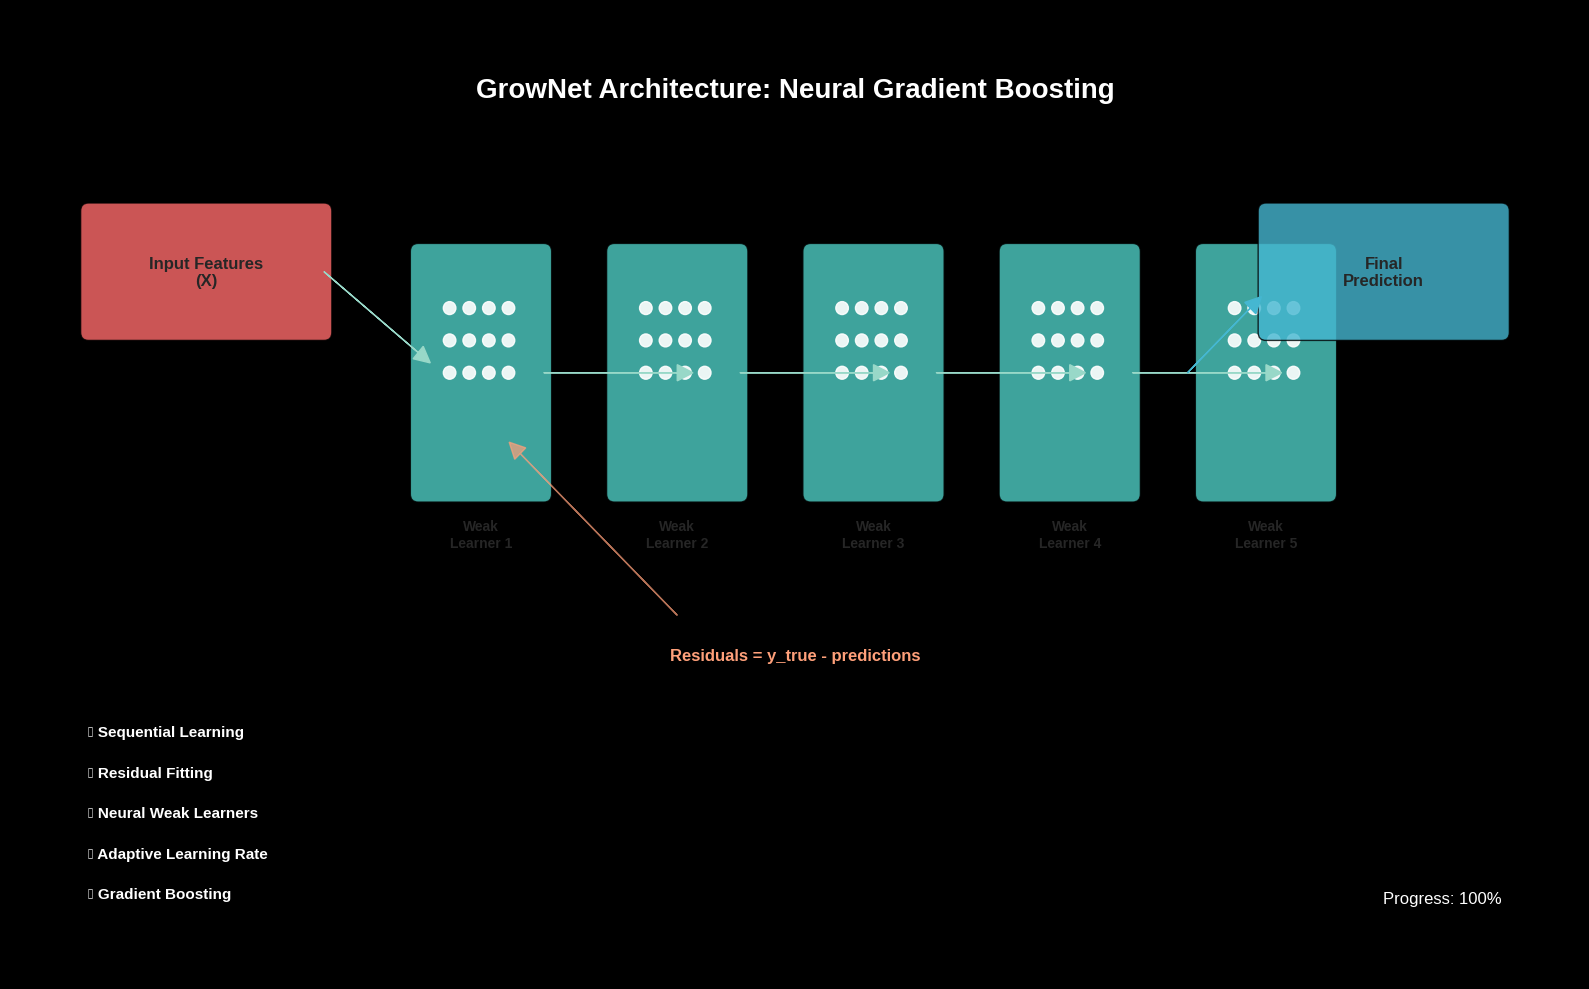

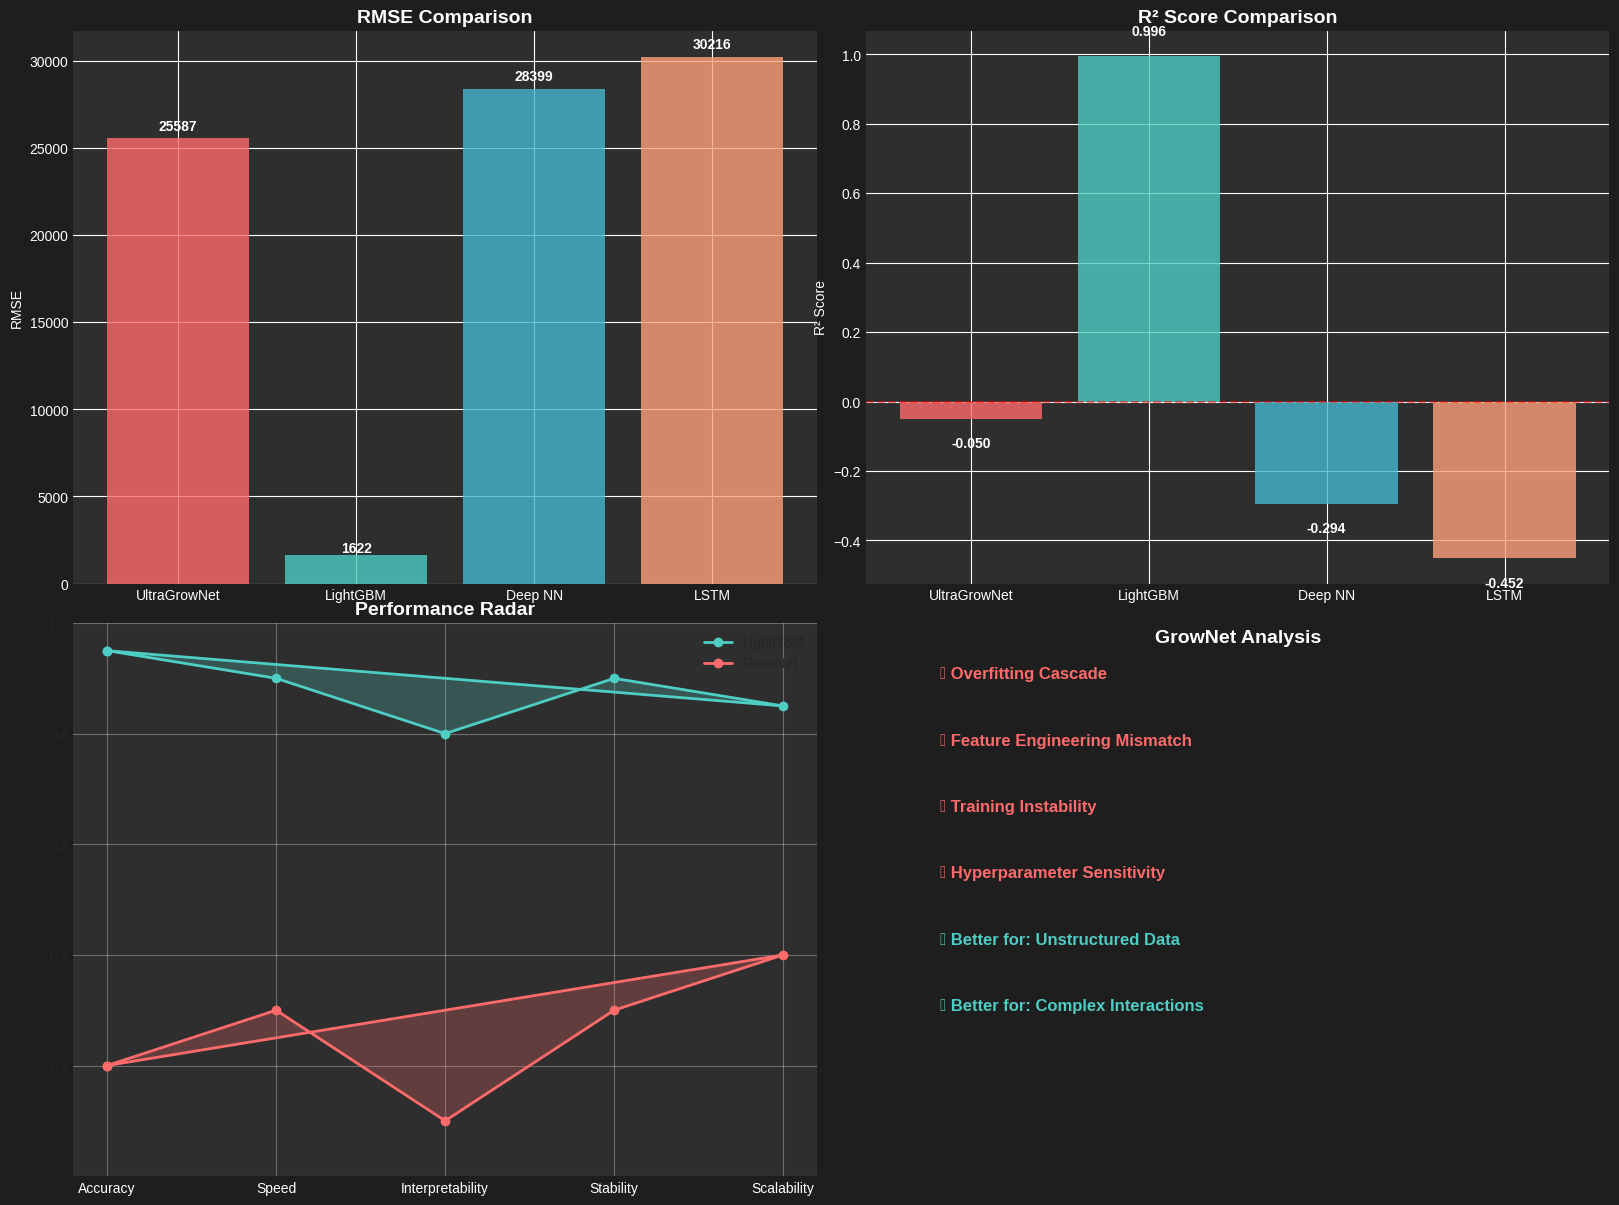

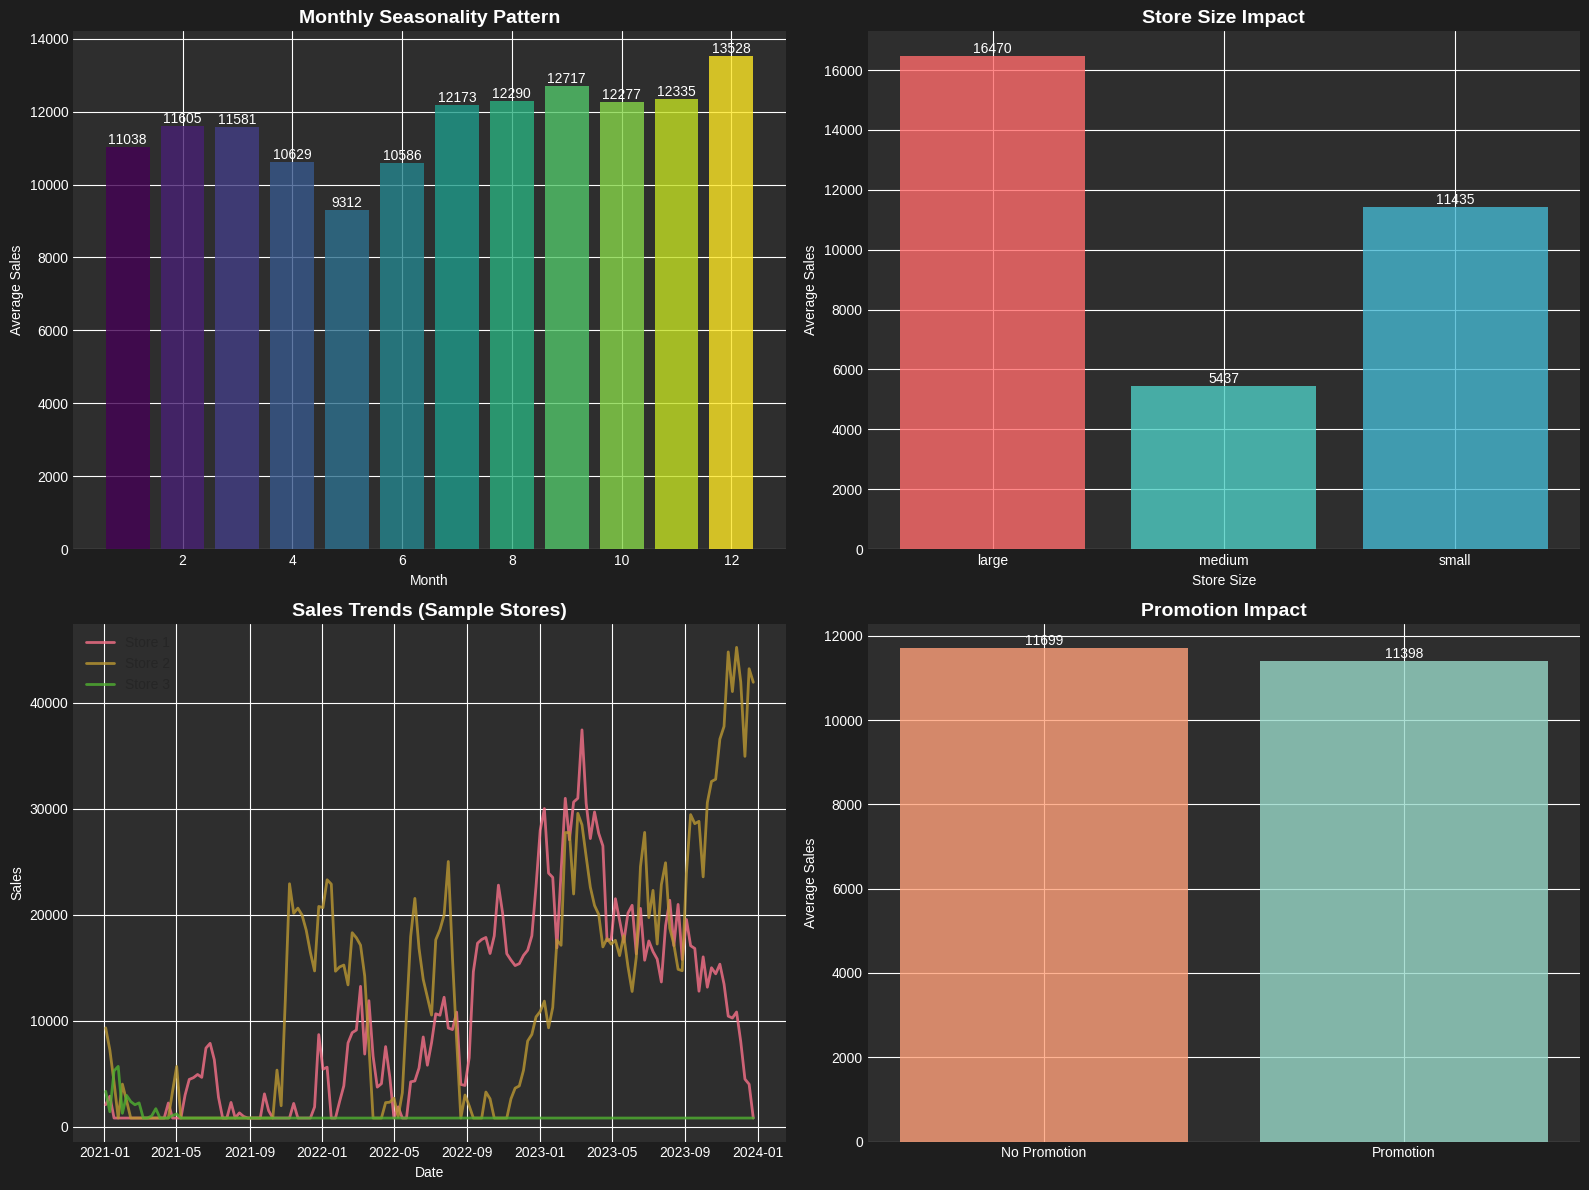

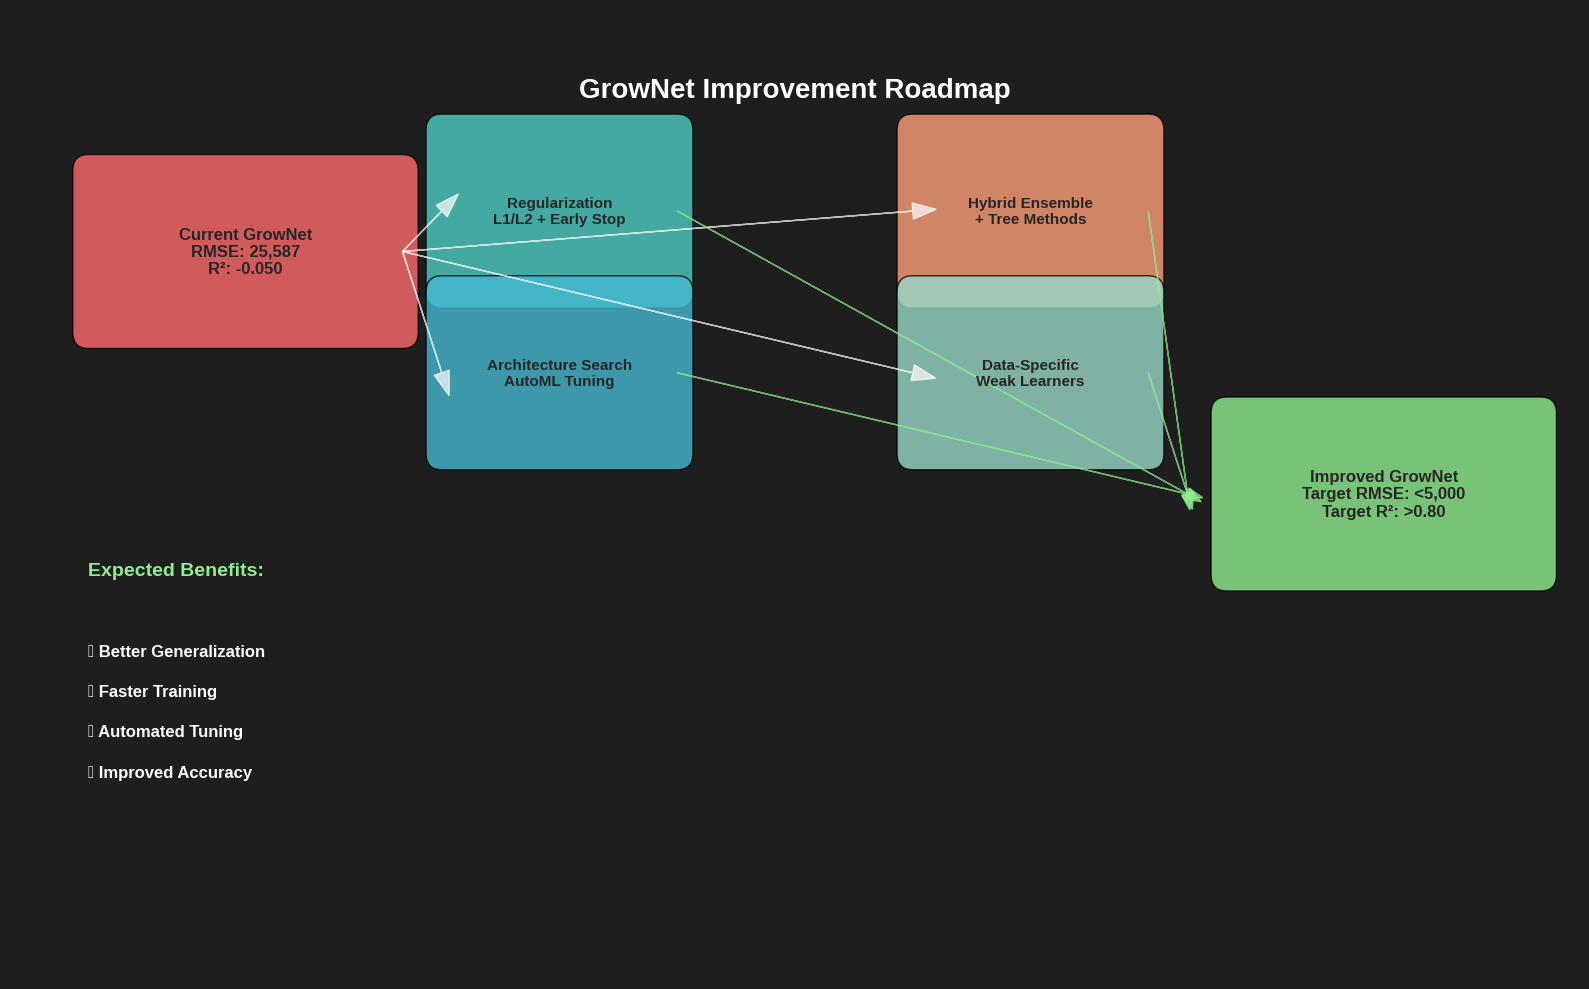


CREATING VISUALIZATIONS


NameError: name 'df' is not defined

In [12]:

if __name__ == "__main__":

    results_df, predictions, ugn_model, viz_objects = enhanced_main()

    # Add visualizations
    print("\n" + "=" * 60)
    print("CREATING VISUALIZATIONS")
    print("=" * 60)

    viz_objects = create_all_visualizations(df, results_df, predictions)